# Final Proj

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mrsteamedbun/AIPI590/blob/main/Final/Final.ipynb)

In [8]:
!sudo apt-get install build-essential libasound2-dev libjack-dev portaudio19-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
libasound2-dev is already the newest version (1.2.6.1-1ubuntu1).
libjack-dev is already the newest version (1:0.125.0-3build2).
The following additional packages will be installed:
  libportaudio2 libportaudiocpp0
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 50 not upgraded.
Need to get 188 kB of archives.
After this operation, 927 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudio2 amd64 19.6.0-1.1 [65.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudiocpp0 amd64 19.6.0-1.1 [16.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 portaudio19-dev amd64 19.6.0-1.1 [106 kB]
Fetched 188 kB in 0s (1,

In [3]:
!pip install pretty_midi shap lime numpy pandas matplotlib

In [1]:
%cd /content
!git clone https://github.com/olaviinha/magenta.git
%cd /content/magenta
!pip install .

!curl -O https://storage.googleapis.com/magentadata/models/performance_rnn.mag
!apt-get update -qq && apt-get install -qq libfluidsynth2 build-essential libasound2-dev libjack-dev
!pip install -U pyfluidsynth

# Hack to allow python to pick up the newly-installed fluidsynth lib.
import ctypes.util
orig_ctypes_util_find_library = ctypes.util.find_library
def proxy_find_library(lib):
  if lib == 'fluidsynth':
    return 'libfluidsynth.so.1'
  else:
    return orig_ctypes_util_find_library(lib)
ctypes.util.find_library = proxy_find_library

# Download Salamander piano SoundFont.
# Samples by Alexander Holm: https://archive.org/details/SalamanderGrandPianoV3
# Converted to sf2 by John Nebauer: https://sites.google.com/site/soundfonts4u
!gsutil -m cp gs://download.magenta.tensorflow.org/soundfonts/Yamaha-C5-Salamander-JNv5.1.sf2 /tmp/
!!wget -O Arabesque-in-E-Nr-1.mid https://raw.githubusercontent.com/mrsteamedbun/AIPI590/main/Final/midi/Arabesque-in-E-Nr-1.mid

/content
fatal: destination path 'magenta' already exists and is not an empty directory.
/content/magenta
Processing /content/magenta
  Preparing metadata (setup.py) ... done
  Created wheel for magenta: filename=magenta-2.1.4-py3-none-any.whl size=1393370 sha256=809daff563a3a5e66ea8d9338981cbdc4348ed67182b7f535ebf63f8924781c6
  Stored in directory: /tmp/pip-ephem-wheel-cache-dri2b00p/wheels/ca/cb/5b/2e1c482f0a95ab756b73c774cd08e66eb591176f4d831bd172
Successfully built magenta
  Attempting uninstall: magenta
    Found existing installation: magenta 2.1.4
    Uninstalling magenta-2.1.4:
      Successfully uninstalled magenta-2.1.4


In [4]:
import pretty_midi
import numpy as np

def extract_features(midi_file):
    midi_data = pretty_midi.PrettyMIDI(midi_file)
    # Extract tempo
    tempo = np.mean(midi_data.get_tempo_changes()[1])  # Average tempo
    # Extract harmony (chord progression)
    chords = []
    for instrument in midi_data.instruments:
        if not instrument.is_drum:
            chords.extend(instrument.notes)
    harmony = [(note.pitch, note.start, note.end) for note in chords]
    return tempo, harmony

# Example usage
midi_file = 'Arabesque-in-E-Nr-1.mid'
tempo, harmony = extract_features(midi_file)
print(f"Tempo: {tempo}, Harmony: {harmony[:10]}")


Tempo: 120.0, Harmony: [(64, 2.216145833333333, 2.5260416666666665), (69, 2.3828125, 2.5625), (61, 2.0, 2.5625), (73, 2.536458333333333, 2.708333333333333), (76, 2.708333333333333, 2.833333333333333), (78, 2.825520833333333, 2.984375), (75, 3.1197916666666665, 3.3151041666666665), (80, 2.9765625, 3.333333333333333), (71, 3.270833333333333, 3.3619791666666665), (68, 3.3854166666666665, 3.5260416666666665)]


'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.


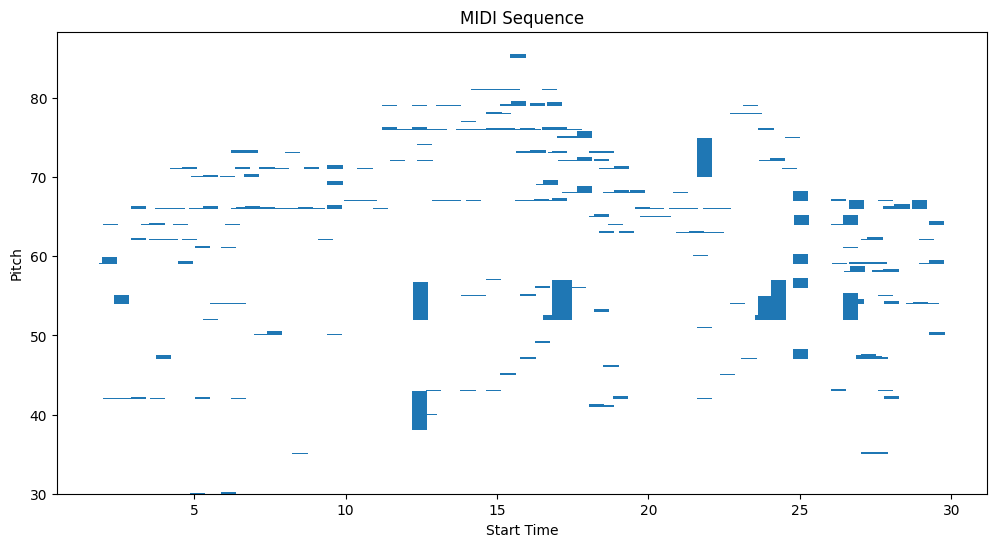

In [5]:
import os
from magenta.models.performance_rnn import performance_sequence_generator
from magenta.models.shared import sequence_generator_bundle
from note_seq.protobuf import generator_pb2
from note_seq.protobuf import music_pb2
import note_seq

import matplotlib.pyplot as plt

def plot_sequence(sequence):
    pitches = [note.pitch for note in sequence.notes]
    start_times = [note.start_time for note in sequence.notes]
    durations = [note.end_time - note.start_time for note in sequence.notes]

    plt.figure(figsize=(12, 6))
    plt.bar(start_times, durations, bottom=pitches, width=0.5)
    plt.xlabel('Start Time')
    plt.ylabel('Pitch')
    plt.title('MIDI Sequence')
    plt.show()

BUNDLE_DIR = '/tmp/'
MODEL_NAME = 'performance_with_dynamics'
BUNDLE_NAME = MODEL_NAME + '.mag'

note_seq.notebook_utils.download_bundle(BUNDLE_NAME, BUNDLE_DIR)
bundle = sequence_generator_bundle.read_bundle_file(os.path.join(BUNDLE_DIR, BUNDLE_NAME))

generator_map = performance_sequence_generator.get_generator_map()
generator = generator_map[MODEL_NAME](checkpoint=None, bundle=bundle)
generator.initialize()
generator_options = generator_pb2.GeneratorOptions()
generator_options.args['temperature'].float_value = 1.0  # Higher is more random; 1.0 is default.
generate_section = generator_options.generate_sections.add(start_time=0, end_time=30)
sequence = generator.generate(music_pb2.NoteSequence(), generator_options)

# Play and view this masterpiece.
plot_sequence(sequence)

In [29]:
class MusicGeneratorWrapper:
    def __init__(self, generator, generator_options):
        self.generator = generator
        self.generator_options = generator_options

    def predict(self, params):
        """
        Generate music based on input parameters and return features.
        Handles LIME's numpy.ndarray input format.
        """
        results = []
        for param in params:  # Iterate over each sample in the batch
            temperature = float(param[0])
            start_time = float(param[1])
            end_time = float(param[2])

            # Debug: Print input values
            print(f"Temperature: {temperature}, Start Time: {start_time}, End Time: {end_time}")

            # Adjust generator options
            self.generator_options.args['temperature'].float_value = temperature
            generate_section = self.generator_options.generate_sections[0]
            generate_section.start_time = start_time
            generate_section.end_time = end_time

            # Debug: Validate generator options
            print(f"Generator Options: {self.generator_options}")

            # Generate music sequence
            try:
                sequence = self.generator.generate(music_pb2.NoteSequence(), self.generator_options)
            except Exception as e:
                print(f"Error during generation: {e}")
                raise

            # Extract features
            features = extract_features(sequence)
            results.append(features)

        return results


In [31]:
import shap
import numpy as np

# Define input parameter ranges for SHAP
param_ranges = np.array([
    [0.5, 1.0, 1.5],  # Temperature
    [0, 10, 20],      # Start Time
    [20, 30, 40]      # End Time
])

# Create SHAP explainer
generator_wrapper = MusicGeneratorWrapper(generator, generator_options)
explainer = shap.Explainer(generator_wrapper.predict, param_ranges)

# Correct the input shape
input_params = np.array([[1.0, 0, 30]])  # Single sample, shape (1, 3)

# Generate SHAP values
shap_values = explainer(input_params)

# Visualize SHAP results
shap.summary_plot(shap_values, feature_names=['Temperature', 'Start Time', 'End Time'])


Temperature: 0.5, Start Time: 1.0, End Time: 1.5
Generator Options: generate_sections {
  start_time: 1.0
  end_time: 1.5
}
args {
  key: "temperature"
  value {
    float_value: 0.5
  }
}



AttributeError: read

NameError: name 'model_predict' is not defined